## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## B. CH Transfer

In [ ]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# Drop Nan entries in millan_v of Norway dataset
data_NOR = data_NOR.dropna(subset=data_NOR.columns.drop('DATA_MODIFICATION'))
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

display(len(data_NOR_CH['GLACIER'].unique()))

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
7,67.31103,16.04244,942,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.321560,56.485962,69.698883
8,67.30629,16.05432,1089,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.424430,147.849106,13.431213
9,67.30809,16.07252,1093,20120925,20130927,-3.02,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30809_16.07252_N_...,38.497514,3.836923,1090.195312,-1.584609,128.302780,31.785975
10,67.29883,16.08302,1153,20120925,20130927,-3.56,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29883_16.08302_N_...,355.618198,3.476761,1152.887817,-1.078567,118.048553,55.155796
11,67.29155,16.06082,1256,20120925,20130927,-2.51,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29155_16.06082_N_...,349.840923,1.787641,1254.803467,-1.107427,258.436462,26.527679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6269,61.74291,7.14345,1796,19611001,19620513,2.38,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.74291_7.14345_N_N_...,181.776838,7.609763,1793.964722,-0.510832,176.193283,14.855300
6270,61.69387,7.11652,1579,19611001,19620513,2.76,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.69387_7.11652_N_N_...,81.210212,13.313894,1570.454346,-0.178745,125.875511,22.823906
6272,68.33479,17.85005,1092,19661020,19670520,1.86,winter,RGI60-08.02436,1967,Blaaisen,Changed TO_DATE year fomr 1966 to 1967,Blaaisen_1967_winter_68.33479_17.85005_N_N_4155,29.882699,17.255500,1050.585938,-1.058776,36.787617,43.074333
6273,61.71461,7.11601,1587,19631001,19640507,2.01,winter,RGI60-08.01126,1964,Nigardsbreen,Changed TO_DATE year fomr 1963 to 1964,Nigardsbreen_1964_winter_61.71461_7.11601_N_N_...,151.305943,4.883604,1586.242676,-1.184982,197.545349,35.713974


Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
0,67.31103,16.04244,942.0,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.32156,56.485962,69.698883
1,67.30629,16.05432,1089.0,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.42443,147.849106,13.431213


69

In [ ]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full_with_millanv_v2.csv')
data_monthly_CH_NOR = dataloader_gl.data

# Add DOMAIN column back using RGI ID patterns
def assign_domain(rgi_id):
    if rgi_id.startswith('RGI60-11'):
        return 0  # Switzerland
    elif rgi_id.startswith('RGI60-08'):
        return 1  # Norway
    else:
        return -1  # Unknown

data_monthly_CH_NOR['DOMAIN'] = data_monthly_CH_NOR['RGIId'].apply(assign_domain)

# Verify domain assignment
print("Domain distribution after assignment:")
print(data_monthly_CH_NOR['DOMAIN'].value_counts())
print(f"Unknown domains (-1): {(data_monthly_CH_NOR['DOMAIN'] == -1).sum()}")

# Update the dataloader with the new data including DOMAIN
dataloader_gl.data = data_monthly_CH_NOR

display(data_monthly_CH_NOR.head(2))

2025-08-25 10:41:08,745 - INFO - Loaded preprocessed data.
2025-08-25 10:41:08,746 - INFO - Number of monthly rows: 347635
2025-08-25 10:41:08,789 - INFO - Number of annual samples: 123778
2025-08-25 10:41:08,830 - INFO - Number of winter samples: 223857


Domain distribution after assignment:
DOMAIN
0    290670
1     56965
Name: count, dtype: int64
Unknown domains (-1): 0


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10,DOMAIN
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947,1
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297,1


In [6]:
# Verify DOMAIN assignment by checking some specific glaciers
print("Sample of DOMAIN assignments:")
sample_glaciers = data_monthly_CH_NOR[['GLACIER', 'RGIId', 'DOMAIN']].drop_duplicates().head(10)
display(sample_glaciers)

# Check if we have both domains represented
ch_glaciers = data_monthly_CH_NOR[data_monthly_CH_NOR['DOMAIN'] == 0]['GLACIER'].nunique()
nor_glaciers = data_monthly_CH_NOR[data_monthly_CH_NOR['DOMAIN'] == 1]['GLACIER'].nunique()
print(f"\nNumber of Swiss glaciers (DOMAIN=0): {ch_glaciers}")
print(f"Number of Norwegian glaciers (DOMAIN=1): {nor_glaciers}")

# Verify some known glaciers
if 'Engabreen' in data_monthly_CH_NOR['GLACIER'].values:
    engabreen_domain = data_monthly_CH_NOR[data_monthly_CH_NOR['GLACIER'] == 'Engabreen']['DOMAIN'].iloc[0]
    print(f"Engabreen (should be 1 for Norway): {engabreen_domain}")

# Check for any Swiss glacier examples
swiss_example = data_monthly_CH_NOR[data_monthly_CH_NOR['DOMAIN'] == 0]['GLACIER'].unique()[:3]
if len(swiss_example) > 0:
    print(f"Example Swiss glaciers: {swiss_example}")
    
print("\nDOMAIN column successfully added to monthly dataset!")

Sample of DOMAIN assignments:


,GLACIER,RGIId,DOMAIN
0,Rundvassbreen,RGI60-08.02384,1
84,Engabreen,RGI60-08.01657,1
188,Aalfotbreen,RGI60-08.02666,1
232,Hansebreen,RGI60-08.02650,1
298,Nigardsbreen,RGI60-08.01126,1
406,Austdalsbreen,RGI60-08.01286,1
490,Juvfonne,RGI60-08.00868,1
502,Hellstugubreen,RGI60-08.00449,1
513,Rembesdalskaaka,RGI60-08.01779,1
583,Svelgjabreen,RGI60-08.02918,1



Number of Swiss glaciers (DOMAIN=0): 38
Number of Norwegian glaciers (DOMAIN=1): 31
Engabreen (should be 1 for Norway): 1
Example Swiss glaciers: ['adler' 'albigna' 'aletsch']

DOMAIN column successfully added to monthly dataset!


In [7]:
# Ensure DOMAIN is part of metadata (so it travels with AggregatedDataset)
if 'DOMAIN' not in cfg.metaData:
    cfg.metaData = cfg.metaData + ['DOMAIN']
print('Metadata columns now:', cfg.metaData)

Metadata columns now: ['RGIId', 'POINT_ID', 'ID', 'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'DOMAIN']


In [8]:
# UDA DATA PREP (CH labeled + NOR unlabeled) using existing DataLoader split for CH validation

# Separate source and target
data_source_full = data_monthly_CH_NOR.query('DOMAIN == 0').copy()
data_target_full = data_monthly_CH_NOR.query('DOMAIN == 1').copy()
print(f"Source (CH) rows: {len(data_source_full)} | Target (NOR) rows: {len(data_target_full)}")

# Build a temporary dataloader with only CH for reproducible val split
_ch_only_loader = mbm.dataloader.DataLoader(cfg, data=data_source_full.copy())
ch_train_itr, ch_val_itr = _ch_only_loader.set_train_test_split(test_size=0.2)
ch_train_idx, ch_val_idx = list(ch_train_itr), list(ch_val_itr)
ch_train_df = data_source_full.iloc[ch_train_idx]
ch_val_df = data_source_full.iloc[ch_val_idx]
print(f"CH split -> train IDs: {len(ch_train_df.ID.unique())} | val IDs: {len(ch_val_df.ID.unique())}")

# Create unlabeled target adaptation copy (labels hidden)
adapt_target_df = data_target_full.copy()
adapt_target_df['POINT_BALANCE'] = np.nan

# Pools
train_pool = pd.concat([ch_train_df, adapt_target_df], axis=0).reset_index(drop=True)
val_pool = ch_val_df.reset_index(drop=True)
eval_pool_target = data_target_full.reset_index(drop=True)  # full NOR with labels for post-training eval

# Assign canonical variables
df_X_train = train_pool; y_train = df_X_train['POINT_BALANCE'].values
df_X_val = val_pool; y_val = df_X_val['POINT_BALANCE'].values
df_X_eval_target = eval_pool_target 
y_eval_target = df_X_eval_target['POINT_BALANCE'].values

print('\nUDA pools created:')
print('  Train total:', len(df_X_train), '| labeled CH rows:', np.isfinite(y_train).sum(), '| unlabeled NOR rows:', np.isnan(y_train).sum())
print('  Val (CH only):', len(df_X_val), '| labeled rows:', np.isfinite(y_val).sum())
print('  Eval NOR (with labels):', len(df_X_eval_target))
# =======================================================================

Source (CH) rows: 290670 | Target (NOR) rows: 56965
CH split -> train IDs: 26685 | val IDs: 6672

UDA pools created:
  Train total: 289567 | labeled CH rows: 232602 | unlabeled NOR rows: 56965
  Val (CH only): 58068 | labeled rows: 58068
  Eval NOR (with labels): 56965


## Neural Network:

In [9]:
# Feature selection for UDA
features_topo = ['ELEVATION_DIFFERENCE'] + list(vois_topographical)
feature_columns = features_topo + list(vois_climate)
cfg.setFeatures(feature_columns)
all_columns = feature_columns + cfg.fieldsNotFeatures

# Subset train/val (target eval later)
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]

print('Shape train:', df_X_train_subset.shape)
print('Shape val:', df_X_val_subset.shape)
print('Running with features:', feature_columns)

Shape train: (289567, 29)
Shape val: (58068, 29)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


In [ ]:
# DANN components: Gradient Reversal, network, regressor wrapper, and dataset bindings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skorch.utils import to_tensor
import massbalancemachine as mbm
from pathlib import Path

class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradReverse(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class DANNNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout=0.2, use_batchnorm=False, domain_hidden=64, grl_lambda=1.0):
        super().__init__()
        layers = []
        current_dim = input_dim
        if not isinstance(dropout, list):
            dropout = [dropout] * len(hidden_layers)
        for hidden_dim, drop_rate in zip(hidden_layers, dropout):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            current_dim = hidden_dim
        self.feature_extractor = nn.Sequential(*layers)
        self.regressor = nn.Linear(current_dim, 1)
        self.grl = GradReverse(lambda_=grl_lambda)
        self.domain_classifier = nn.Sequential(
            nn.Linear(current_dim, domain_hidden),
            nn.ReLU(),
            nn.Dropout(dropout[-1] if isinstance(dropout, list) else dropout),
            nn.Linear(domain_hidden, 1),
        )

    def forward(self, x):
        h = self.feature_extractor(x)
        y_pred = self.regressor(h)
        d_logits = self.domain_classifier(self.grl(h))
        return y_pred, d_logits

# Dataset that yields domain labels padded per ID to match monthly padding
class DomainTargetDataset(torch.utils.data.Dataset):
    def __init__(self, aggregated_dataset):
        self.base = aggregated_dataset
        self.meta_has_domain = 'DOMAIN' in self.base.metadataColumns
        if not self.meta_has_domain:
            # fallback: try to read from features
            assert 'DOMAIN' in self.base.cfg.featureColumns, "DOMAIN required"
            self.domain_feat_idx = self.base.cfg.featureColumns.index('DOMAIN')
        else:
            self.domain_idx = self.base.metadataColumns.index('DOMAIN')
    def __len__(self):
        return len(self.base)
    def __getitem__(self, index):
        ind = self.base._getInd(index)
        if self.meta_has_domain:
            dval = self.base.metadata[ind[0]][self.domain_idx]
        else:
            dval = self.base.features[ind[0], self.domain_feat_idx]
        dpad = np.empty(self.base.maxConcatNb, dtype=np.float32)
        dpad.fill(np.nan)
        dpad[:len(ind)] = dval
        return dpad

# Binding that returns (X, (y, d)) so y_true in get_loss can contain both
class CombinedTargetBinding(torch.utils.data.Dataset):
    def __init__(self, X_slice, y_slice, d_dataset):
        self.X = X_slice
        self.y = y_slice
        self.d = d_dataset
        assert len(self.X) == len(self.y) == len(self.d)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], (self.y[idx], self.d[idx])
    
# Skorch regressor that adds domain-adversarial loss on top of the SMB loss
class CustomDANNRegressor(mbm.models.CustomNeuralNetRegressor):
    def __init__(self, cfg, *args, dan_lambda=0.1, **kwargs):
        super().__init__(cfg, *args, **kwargs)
        self.dan_lambda = dan_lambda
        self._last_domain_logits = None

    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if len(x.shape) == 1: x = x[None]
        x, indNonNan = self._unpack_inp(x)
        if self.modelDtype is not None: x = x.type(self.modelDtype)
        outputs = self.module_(x, **fit_params)
        if isinstance(outputs, tuple):
            y_monthly, d_monthly = outputs
            y_packed = self._pack_out(y_monthly, indNonNan)
            d_packed = self._pack_out(d_monthly, indNonNan)
            self._last_domain_logits = d_packed
            return y_packed
        return self._pack_out(outputs, indNonNan)
    
    def get_loss(self, y_pred, y_true, X=None, training=False):
        if isinstance(y_true, (tuple, list)) and len(y_true) == 2:
            y_true_labels, y_true_domain = y_true
        else:
            y_true_labels, y_true_domain = y_true, None

        # Label loss (same as base implementation)  
        loss = 0.0; cnt = 0
        for yi_pred, yi_true in zip(y_pred, y_true_labels):
            valid = ~torch.isnan(yi_true) # Changed from yi_pred to yi_true to not only maks padded month but target domain NaN model predictions
            if valid.any():
                pred_sum = yi_pred[valid].sum()
                true_mean = yi_true[valid].mean()
                loss += (pred_sum - true_mean) ** 2
                cnt += 1
        label_loss = loss / max(cnt, 1)

        # Domain loss a bit more complicated due to Per-ID mean and then batch mean for each domain
        # otherwise IDs with longer months have higher domain loss and CH domain loss with more data is exaggerated
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits
            per_id_losses_ch, per_id_losses_nor = [], []    # track losses separately, so we can average them individually later

            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                if d_log_row.ndim > 1: 
                    d_log_row = d_log_row.squeeze(-1)

                mask = ~torch.isnan(d_true_row) # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    # domain for this ID (same across valid months)
                    dom_i = int(d_true_row[mask][0].item())
                    (per_id_losses_ch if dom_i == 0 else per_id_losses_nor).append(loss_i)
            parts = []
            if len(per_id_losses_ch) > 0:
                parts.append(torch.stack(per_id_losses_ch).mean())
            if len(per_id_losses_nor) > 0:
                parts.append(torch.stack(per_id_losses_nor).mean())
            if len(parts) > 0:
                domain_loss = torch.stack(parts).mean()

        return label_loss + self.dan_lambda * domain_loss
    @staticmethod
    def load_model(cfg, fname: str, *args, **kwargs):
        model = CustomDANNRegressor(cfg, *args, **kwargs)
        model.initialize(); models_dir = Path('./models')
        model.load_params(f_params=models_dir / fname)
        return model

In [11]:
# Check the current Norway feature order
print("Current Norway feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current Norway feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10


### Initialise network:

In [12]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
    'module__domain_hidden': 64,
    'module__grl_lambda': 1.0,
}

# Use DANN network
args = {
    'module': DANNNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'module__domain_hidden': params['module__domain_hidden'],
    'module__grl_lambda': params['module__grl_lambda'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

# DANN loss weight
DAN_LAMBDA = 0.1
custom_nn = CustomDANNRegressor(cfg, dan_lambda=DAN_LAMBDA, **args, **param_init)

### Create datasets:

In [13]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the aggregated datasets
agg_train = mbm.data_processing.AggregatedDataset(cfg,
                                                  features=features,
                                                  metadata=metadata,
                                                  targets=y_train)
agg_val = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features_val,
                                                metadata=metadata_val,
                                                targets=y_val)

# Build domain targets per ID
domain_train_ds = DomainTargetDataset(agg_train)
domain_val_ds = DomainTargetDataset(agg_val)

# Slice features/labels
X_train_slice = SliceDataset(agg_train, idx=0)
y_train_slice = SliceDataset(agg_train, idx=1)
X_val_slice = SliceDataset(agg_val, idx=0)
y_val_slice = SliceDataset(agg_val, idx=1)

# Bind (X, (y, d)) so CustomDANNRegressor receives both labels and domains
dataset = CombinedTargetBinding(X_train_slice, y_train_slice, domain_train_ds)
dataset_val = CombinedTargetBinding(X_val_slice, y_val_slice, domain_val_ds)

# For info
print("train:", len(dataset))
print("validation:", len(dataset_val))

train: 32644
validation: 6672


In [14]:
# Domain-balanced sampling (~50/50 CH:ICE) using WeightedRandomSampler
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler

# Map each training aggregated item (ID) to its DOMAIN
# 1) get the ID per aggregated sample in the training SliceDataset
train_ids = X_train_slice.dataset.indexToId(list(range(len(X_train_slice))))

# 2) build an ID -> DOMAIN dict from the training dataframe
id_to_domain = (
    df_X_train_subset.groupby('ID')['DOMAIN'].first().to_dict()
)

# 3) lookup domains per training aggregated item
sample_domains = np.array([id_to_domain.get(i, -1) for i in train_ids], dtype=int)

# Safety: ensure only CH(0) and NOR(1) are present; any other values get zero weight
n_ch = int((sample_domains == 0).sum())
n_nor = int((sample_domains == 1).sum())
if (n_ch + n_nor) == 0:
    raise ValueError("No CH/NOR samples found in training set for sampler.")

# Compute weights so the expected sampling is 50% CH and 50% NOR per epoch
w = np.zeros_like(sample_domains, dtype=float)
if n_ch > 0:
    w[sample_domains == 0] = 0.5 / n_ch
if n_nor > 0:
    w[sample_domains == 1] = 0.5 / n_nor
# Any unknown domains remain with weight 0 (won't be sampled)

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(w, dtype=torch.double),
    num_samples=len(w),   # one epoch worth of samples, drawn with replacement
    replacement=True,
)

# Sanity Check
# Single simulated epoch
sim_idx = list(iter(WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double),
                                         num_samples=len(w),
                                         replacement=True)))
sim_ratio = (sample_domains[sim_idx] == 1).mean()  # NOR share
print(f"Simulated epoch: NOR share={sim_ratio:.3f}, unique IDs drawn={len(set(sim_idx))}/{len(w)}")

# Optional: a few repeats to see variance
for t in range(3):
    idx_t = list(iter(WeightedRandomSampler(torch.as_tensor(w, dtype=torch.double),
                                           num_samples=len(w),
                                           replacement=True)))
    print(f" trial {t+1}: NOR={(sample_domains[idx_t] == 1).mean():.3f}, unique={len(set(idx_t))}")

# --- end diagnostic ---

# Plug into skorch (disable shuffle when using a sampler)
custom_nn = custom_nn.set_params(
    iterator_train__sampler=sampler,
    iterator_train__shuffle=False,
    iterator_train__batch_sampler=None,  # ensure no clash if set elsewhere
)

print(f"Sampler configured: CH IDs={n_ch}, NOR IDs={n_nor}, total train items={len(w)}")

Simulated epoch: NOR share=0.502, unique IDs drawn=17771/32644
 trial 1: NOR=0.496, unique=17866
 trial 2: NOR=0.496, unique=17852
 trial 3: NOR=0.503, unique=17821
Sampler configured: CH IDs=26685, NOR IDs=5959, total train items=32644


### Train custom model:

In [ ]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the DANN model...")
    print('Model parameters:')
    for key, value in args.items():
        if key == 'module':
            print(f"{key}: DANNNetwork")
        else:
            print(f"{key}: {value}")
    print(f"dan_lambda: {DAN_LAMBDA}")
    custom_nn.fit(dataset, None)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"dann_model_crossregional_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"dann_params_crossregional_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump({**args, 'dan_lambda': DAN_LAMBDA}, f)

else:
    # Load model and set to CPU
    model_filename = "dann_model_2025-08-19_2nd_try_4_glaciers_50%_lamba0_05_mean_domainloss_even_domainloss_only_NOR_val.pt"  # Replace if needed
    loaded_model = CustomDANNRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

In [16]:
# Load model and set to CPU
model_filename = "dann_model_crossregional_2025-08-25_lambda0_1_mean_domainloss_even_domainloss_50_50_epochsplit_grllambdascheduling.pt"  # Replace if needed
loaded_model = CustomDANNRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Evaluation on NOR (post-adaptation)

In [17]:
df_X_eval_target_subset = df_X_eval_target[all_columns]

feat_target, meta_target = loaded_model._create_features_metadata(df_X_eval_target_subset)
agg_target = mbm.data_processing.AggregatedDataset(cfg, features=feat_target, metadata=meta_target, targets=y_eval_target)
X_target = SliceDataset(agg_target, idx=0)
y_target = SliceDataset(agg_target, idx=1)

y_pred_monthly = loaded_model.predict(X_target)
y_pred_aggr = loaded_model.aggrPredict(X_target)

batchIndex = np.arange(len(y_pred_aggr))
y_true_aggr = np.array([e for e in y_target[batchIndex]])

mse_t, rmse_t, mae_t, pearson_t = loaded_model.evalMetrics(y_pred_monthly, y_true_aggr)
print(f"NOR Evaluation (simple) -> RMSE: {rmse_t:.4f} | MAE: {mae_t:.4f} | Pearson: {pearson_t:.4f}")

NOR Evaluation (simple) -> RMSE: 1.5701 | MAE: 1.0934 | Pearson: 0.7745


NOR (legacy style) -> RMSE: 1.5701 | MAE: 1.0934 | Pearson: 0.7745 | Score (skorch): -2.4651


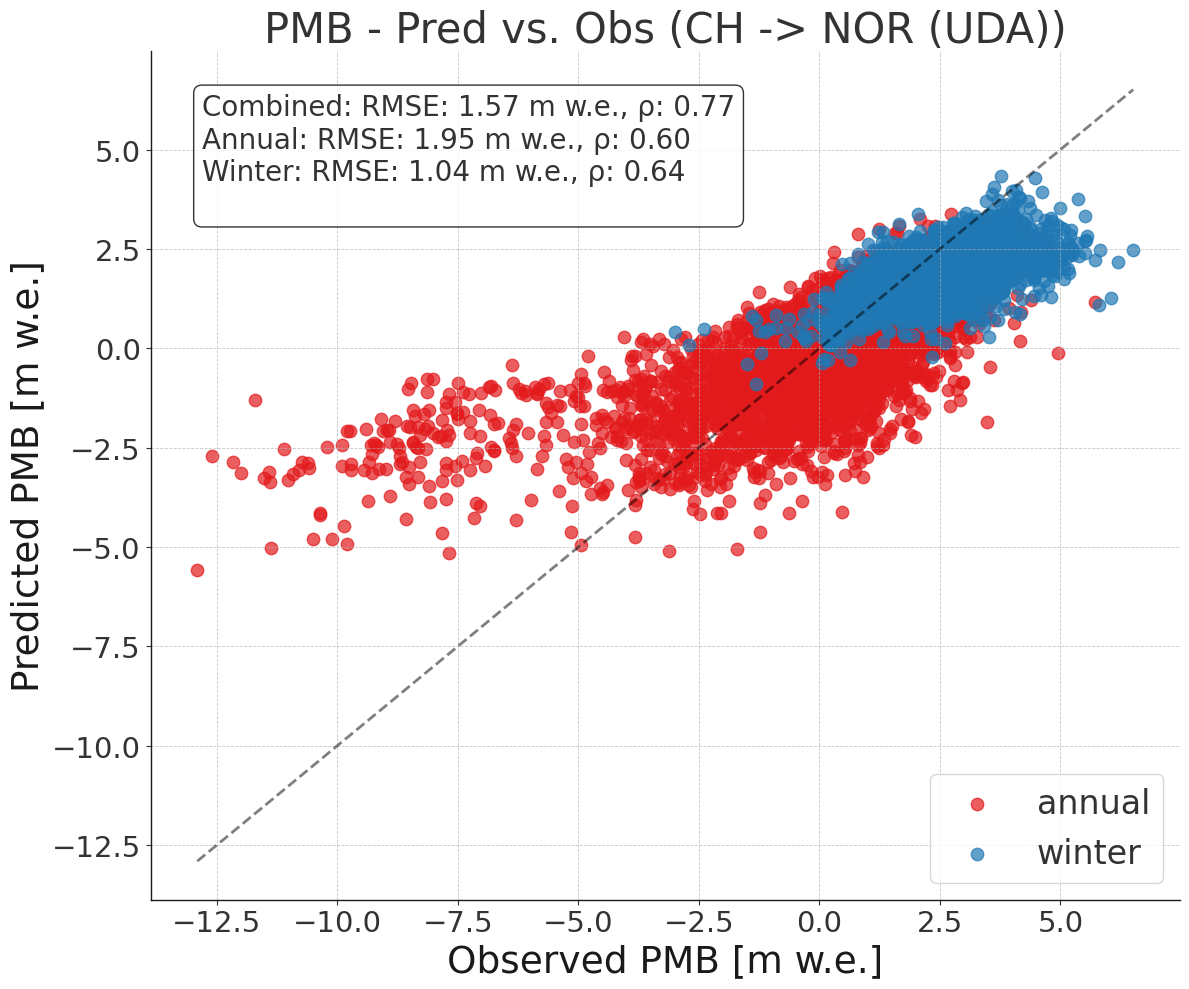

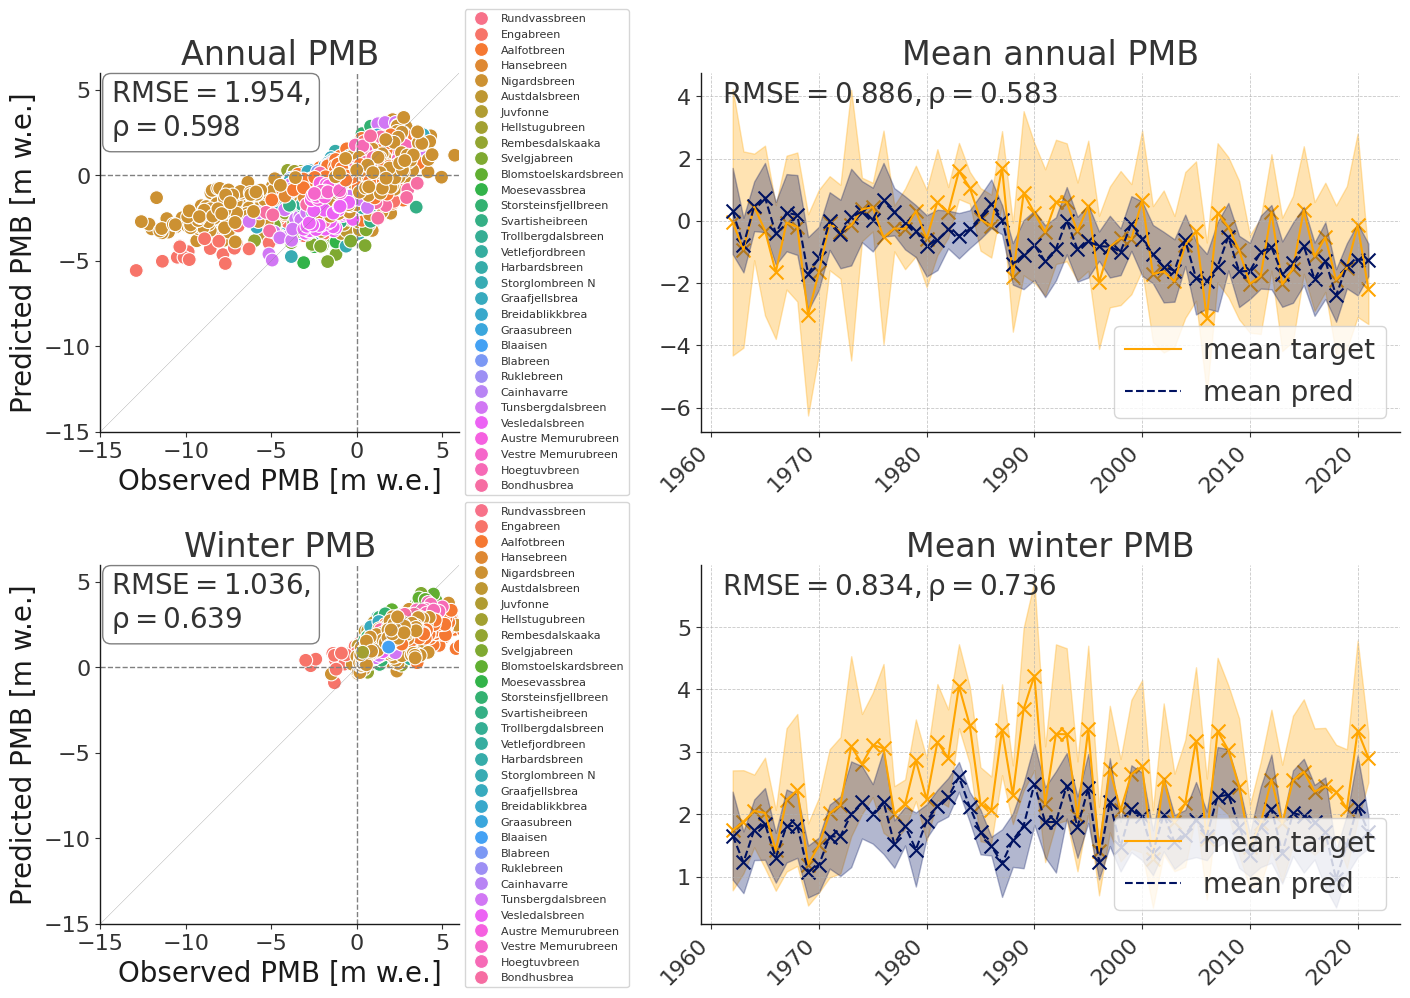

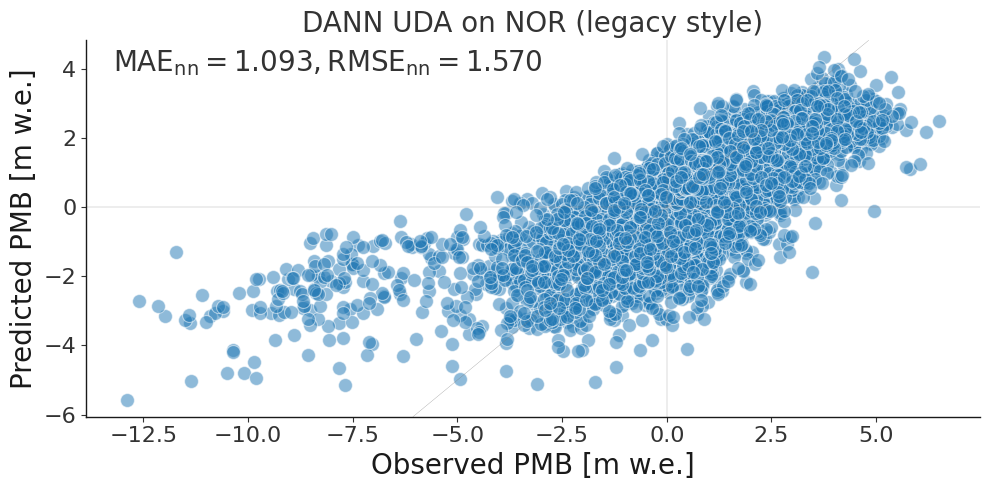

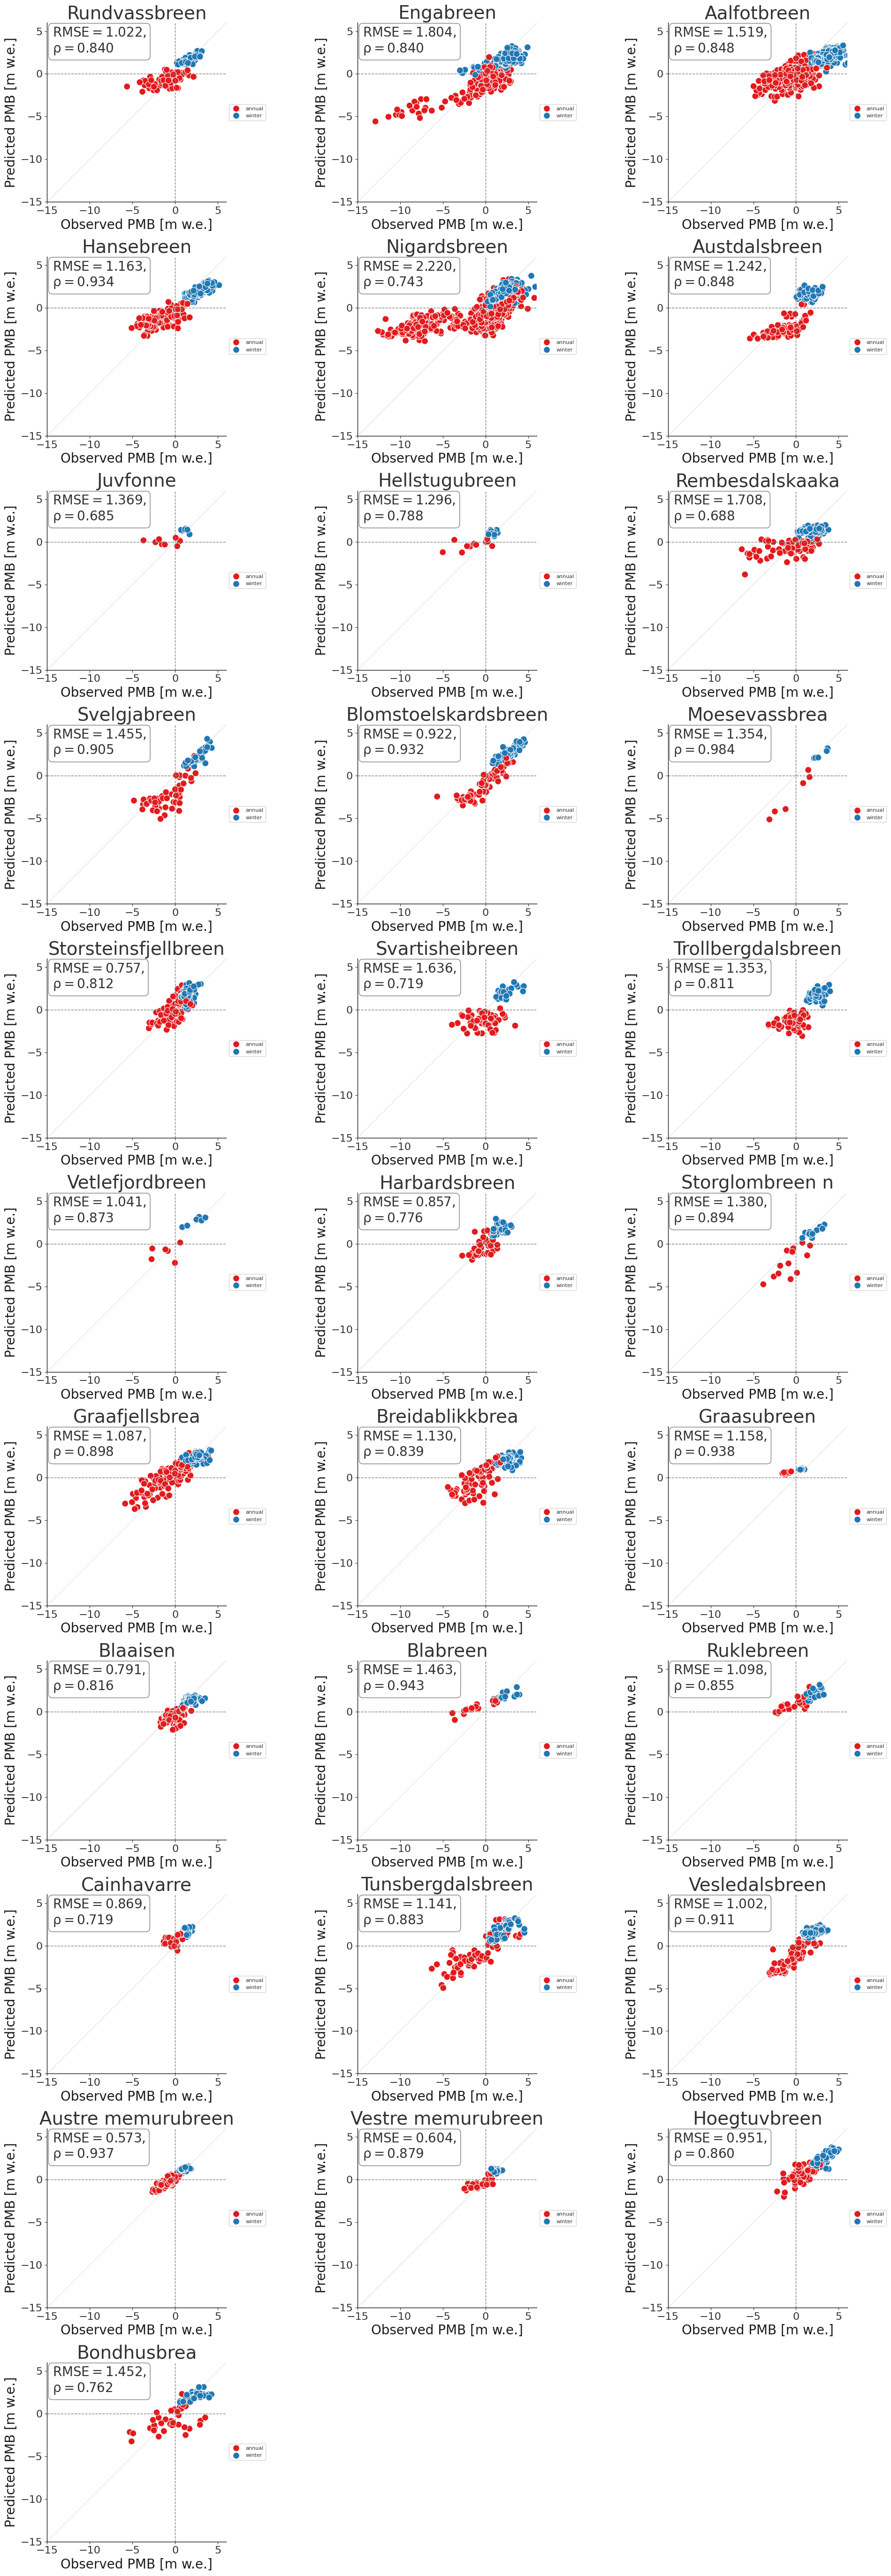

In [18]:
# Build features/metadata for target evaluation set (Norway full labeled)
features_eval, metadata_eval = loaded_model._create_features_metadata(df_X_eval_target_subset)

# Move to CPU if needed
if hasattr(features_eval, 'cpu'):
    features_eval = features_eval.cpu()

targets_eval = y_eval_target
if hasattr(targets_eval, 'cpu'):
    targets_eval = targets_eval.cpu()


# Aggregated dataset and sliced view (X, y)
agg_eval = mbm.data_processing.AggregatedDataset(cfg,
                                                 features=features_eval,
                                                 metadata=metadata_eval,
                                                 targets=targets_eval)
X_eval_slice = SliceDataset(agg_eval, idx=0)
y_eval_slice = SliceDataset(agg_eval, idx=1)

y_pred_monthly_full = loaded_model.predict(X_eval_slice)
y_pred_agg_full = loaded_model.aggrPredict(X_eval_slice)

batchIndex_full = np.arange(len(y_pred_agg_full))
y_true_agg_full = np.array([e for e in y_eval_slice[batchIndex_full]])

# Metrics (score uses model.score which may aggregate differently; keep both)
score_full = loaded_model.score(X_eval_slice, y_eval_slice)
mse_full, rmse_full, mae_full, pearson_full = loaded_model.evalMetrics(y_pred_monthly_full, y_true_agg_full)
print(f"NOR (legacy style) -> RMSE: {rmse_full:.4f} | MAE: {mae_full:.4f} | Pearson: {pearson_full:.4f} | Score (skorch): {score_full:.4f}")

# Aggregate predictions into DataFrame per ID
eval_ids = X_eval_slice.dataset.indexToId(batchIndex_full)
data_rows = {
    'target': [e[0] for e in y_eval_slice],  # original summed/mean target per ID (depends on base class semantics)
    'ID': eval_ids,
    'pred': y_pred_agg_full,
}
grouped_ids = pd.DataFrame(data_rows)

# Merge ancillary columns (PERIOD, GLACIER, YEAR) from evaluation subset dataframe
periods_per_ids = df_X_eval_target_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID', how='left')

glaciers_per_ids = df_X_eval_target_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glaciers_per_ids, on='ID', how='left')

years_per_ids = df_X_eval_target_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID', how='left')

# Plots matching former workflow (region_name label updated)

PlotPredictionsCombined_NN(grouped_ids, region_name='CH -> NOR (UDA)', include_summer=False)
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae_full, rmse_full, title='DANN UDA on NOR (legacy style)')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))


# grouped_ids now holds per-ID predictions and can be reused downstream

In [ ]:
# Domain confusion analysis - Check if DANN learned domain-invariant features
print("Running domain confusion analysis...")

with torch.no_grad():
    loaded_model.module_.eval()
    
    # Get domain predictions for both CH and NOR
    ch_domain_preds = []
    nor_domain_preds = []
    
    # Use CH validation data
    for i, (x, (y, d)) in enumerate(dataset_val):
        if i > 20: break
        
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        x_processed, _ = loaded_model._unpack_inp(x_tensor)
        y_pred, d_logits = loaded_model.module_(x_processed)
        d_prob = torch.sigmoid(d_logits.squeeze()).mean().item()
        
        domain_label = d[0].item() if not np.isnan(d[0].item()) else None
        if domain_label == 0:  # CH
            ch_domain_preds.append(d_prob)
    
    # Use NOR evaluation data for NOR samples
    for i, x in enumerate(X_eval_slice):
        if i > 20: break
        
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        x_processed, _ = loaded_model._unpack_inp(x_tensor)
        y_pred, d_logits = loaded_model.module_(x_processed)
        d_prob = torch.sigmoid(d_logits.squeeze()).mean().item()
        nor_domain_preds.append(d_prob)
    
    if len(ch_domain_preds) > 0 and len(nor_domain_preds) > 0:
        print(f"CH domain predictions (should be ~0.5): {np.mean(ch_domain_preds):.3f} ± {np.std(ch_domain_preds):.3f}")
        print(f"NOR domain predictions (should be ~0.5): {np.mean(nor_domain_preds):.3f} ± {np.std(nor_domain_preds):.3f}")
        
        # Interpretation
        ch_mean = np.mean(ch_domain_preds)
        nor_mean = np.mean(nor_domain_preds)
        domain_separation = abs(ch_mean - nor_mean)
        
        if abs(ch_mean - 0.5) < 0.15 and abs(nor_mean - 0.5) < 0.15:
            print("Domain confusion SUCCESS: Model learned domain-invariant features!")
        else:
            print("Domain confusion FAILED: Model can still distinguish domains")
        
        print(f"   Domain separation: {domain_separation:.3f} (closer to 0 is better)")
        print(f"   CH mean distance from 0.5: {abs(ch_mean - 0.5):.3f}")
        print(f"   NOR mean distance from 0.5: {abs(nor_mean - 0.5):.3f}")
    else:
        print(f"Could not analyze domain confusion - CH samples: {len(ch_domain_preds)}, NOR samples: {len(nor_domain_preds)}")